# Processing of Doppler wind data from a Swiss volumetric scan

In this exercice we will load raw unfiltered Swiss C-band data during a thunderstorm event and process it to estimate at profile of horizontal wind aloft the radar. The following topics will be tackled.

- Dealiasing of radial velocity
- CAPPI plots and profiles
- PseudoRHI profiles
- Computation of a VAD (velocity azimuth display)


In [2]:
# Imports

import numpy as np
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import glob

import pyart
pyart.config.load_config('mch_config.py')



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



The Swiss operational C-band radar network performs 20 PPIs at 20 different elevations (from 0.2° to 40°) every 5 minutes. All PPIs are stored in separate files. 

We will thus read all 20 elevations one after the other for a given timestep and use the Py-ART function __[join_radar](https://arm-doe.github.io/pyart/API/generated/pyart.util.join_radar.html?highlight=join_radar)__ to merge them all into a single radar object which containes 20 sweeps. 

To avoid using too much memory we will read the pre-processed MeteoSwiss radar data which has a resolution of 500 m in range.

Every time we read a file we will also dealias the radial velocity field. Indeed, at lower elevations, low PRFs are used which result in low Nyquist velocities between 8-12 m/s. This means that a lot of raveling will occur, especially in strong winds. In this example we use the simplest dealiasing method of Py-ART which performs by finding regions of similar velocities and unfolding and merging pairs of regions until all regions are unfolded.

In [3]:
# Read all 20 elevations for one timestep
files_radar = sorted(glob.glob('./data/exercice2_swiss_doppler/MLL221790725*'))
for i,f in enumerate(files_radar):
    radar = pyart.io.read_cfradial(f)
    
    if i == 0:
        radar_merged = radar
    else:
        radar_merged = pyart.util.join_radar(radar_merged, 
                                       radar)
        
corr_vel = pyart.correct.dealias_region_based(radar_merged)
radar_merged.add_field('corrected_velocity', corr_vel)

We will now plot the raw and dealiased velocities at two different elevations to see the effect of the correction.



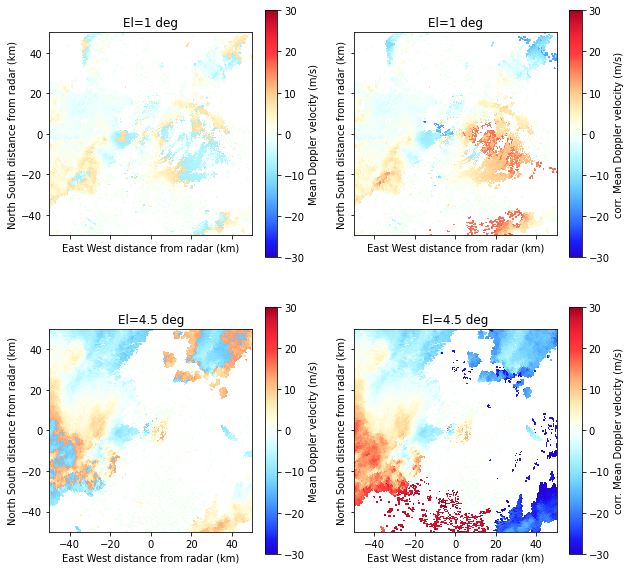

In [4]:
fig, ax = plt.subplots(2,2, figsize=(10,10), sharex= True, sharey=True)
ax = ax.ravel()
display = pyart.graph.RadarDisplay(radar_merged)
display.plot_ppi('velocity', 2, vmin=-30, vmax=30., ax = ax[0], title='El=1 deg',
                 colorbar_label = 'Mean Doppler velocity (m/s)')
display.plot_ppi('corrected_velocity', 2, vmin=-30, vmax=30., title='El=1 deg',
                      ax = ax[1], colorbar_label = 'corr. Mean Doppler velocity (m/s)')
display.plot_ppi('velocity', 6, vmin=-30, vmax=30., ax = ax[2], title='El=4.5 deg',
                 colorbar_label = 'Mean Doppler velocity (m/s)')
display.plot_ppi('corrected_velocity', 6, vmin=-30, vmax=30., title='El=4.5 deg',
                      ax = ax[3], colorbar_label = 'corr. Mean Doppler velocity (m/s)')
ax[0].set_xlim([-50,50])
ax[0].set_ylim([-50,50])
for a in ax:
    a.set_aspect('equal', 'box')

Indeed the raw velocity shows alternating bands of negative and positive velocities which indicates aliasing. The dealiased velocity looks much less discontinuous. Note however that a major difficulty for these algorithms is the presence of isolated pixels, which tend to get arbitrary values as can be seen in the south of the radar.

We will now create a CAPPI (constant altitude PPI) of the reflectivity during this event. The idea is to interpolate the volumetric scan on a 3D Cartesian grid using the function __[grid_from_radars](https://arm-doe.github.io/pyart/API/generated/pyart.map.grid_from_radars.html)__. Here we will create slices every 500 m from 500 m to 8000 m above the radar.

In [5]:
zmin = 500
zmax = 8000
ymin= xmin = -100000
ymax = xmax = 100000
lat = float(radar.latitude['data'])
lon = float(radar.longitude['data'])
alt = float(radar.altitude['data'])
# number of grid points in cappi
cappi_res_h = 500
cappi_res_v = 500
ny = int((ymax-ymin)/cappi_res_h)+1
nx = int((xmax-xmin)/cappi_res_h)+1
nz = int((zmax-zmin)/cappi_res_v)+1

cappi_zh = pyart.map.grid_from_radars(radar_merged, grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax),
                     (xmin, xmax)),
        fields=['reflectivity'])


Now we plot the reflectivity at 4 different altitudes (0.5, 3, 5.5 and 8 km), as well as a profile along as a W-E profile at the radar location throught the thunderstorm.

In [ ]:
display = pyart.graph.GridMapDisplay(cappi_zh)
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,14))
ax = plt.subplot(221, projection = projection)
display.plot_grid('reflectivity',0, ax = ax, projection = projection)
ax = plt.subplot(222, projection = projection)
display.plot_grid('reflectivity',5, ax = ax, projection = projection)
ax = plt.subplot(223, projection = projection)
display.plot_grid('reflectivity',10, ax = ax, projection = projection)
ax = plt.subplot(224, projection = projection)
display.plot_grid('reflectivity',15, ax = ax, projection = projection)

ax = fig.add_axes([0.25, -0.20, .5, .25])
display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, ax = ax)


We will now create a pseudo RHI (altitudinal cross-section through a set of PPIs) of the radial velocity and the reflectivity through the thunderstorm at azimuth 270° (to the west).

In [ ]:
pseudorhi = pyart.util.cross_section_ppi(radar_merged, [270])

display = pyart.graph.RadarDisplay(pseudorhi)
fig, ax = plt.subplots(2,1, sharex=True,sharey=True, figsize= (10,10))
display.plot_rhi('corrected_velocity', ax = ax[0], vmin = -30, vmax = 30)
display.plot_rhi('reflectivity', ax = ax[1])
ax[0].set_ylim([0,20])
ax[0].set_xlim([0,100])



The convention at MeteoSwiss (which is different from the one used by Py-ART) is that positive velocities are moving away from the radar. In this example we see clearly the downdraft in the center of storm and the updraft in its surroundings.

We will now make a VAD retrieval to estimate the horizontal wind profile above the radar. This technique requires to have measurements in as many azimuths as possible and works better for stratiform rain when the radar coverage is wider. We will load data from a cold front event on the 13th July 2021 near the Albis radar (south of Zürich), that showed widespread precipitation around the radar. 

Unfortunately the VAD estimation technique in Py-ART can process only one sweep at a time. So we will average the wind vectors obtained over all sweeps to obtain a more reliable estimate. Note that we skip the first four sweeps which are more prone to ground echoes and have a very low Nyquist velocity.

In [ ]:
files_radar = sorted(glob.glob('./data/question_pyart_meteoswiss/MLA211941205*'))
u_allsweeps = []
v_allsweeps = [] 
zlevels = np.arange(100,5000,100)
speed = []
for i,f in enumerate(files_radar[4:]):
    radar = pyart.io.read_cfradial(f)
    corr_vel = pyart.correct.dealias_region_based(radar)
    corr_vel['data'] *= -1 
    radar.add_field('corrected_velocity_neg', corr_vel)
    
    vad = pyart.retrieve.vad_browning(radar, 'corrected_velocity_neg', z_want = zlevels)
    u_allsweeps.append(vad.u_wind)
    v_allsweeps.append(vad.v_wind)
    
u_avg = np.nanmean(np.array(u_allsweeps), axis = 0)
v_avg = np.nanmean(np.array(v_allsweeps), axis = 0)
orientation = np.rad2deg(np.arctan2(-u_avg, -v_avg))%360
speed = np.sqrt(u_avg**2 + v_avg**2)


Note that because the convention at MeteoSwiss is different than the one in Py-ART we have to flip the sign of the radial velocity field. 

Finally we do a plot of the vertical profiles or horizontal wind speed and direction

In [ ]:
fig,ax = plt.subplots(1,2, sharey=True)
ax[0].plot(speed*2, zlevels+radar.altitude['data'])
ax[1].plot(orientation, zlevels+radar.altitude['data'])
ax[0].set_xlabel('Wind speed [m/s]')
ax[1].set_xlabel('Wind direction [deg]')
ax[0].set_ylabel('Altitude [m]')
fig.suptitle('Wind profile obtained from VAD')

Now let's compare this wind profile with the one recorded by the nearest radiosounding operated in Payerne (around 130 km west from the radar):


<div>
<img src="./images/radiosounding_pay_20210713.png" width="400">
</div>

Though there are some discrepancies the match is not bad, given the distance and the very different ways of measuring wind!